
# Maximal Representative Subsampling


<div class="alert alert- block alert-warning"> <b>Todo:</b> 

- Use unprundes trees

- Try linear svm with C param tuning

</div>

In [38]:
from pathlib import Path
import os

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from scipy import stats

import pandas as pd
pd.options.mode.chained_assignment = None

import matplotlib.pyplot as plt
import numpy as np
np.seterr(divide = 'ignore')
import random

path = Path(os.getcwd()).parent

### Plots

In [146]:
def plot_results(score, n, title):

    labels = [s[0] for s in score]
    preds = [s[1] for s in score]

    ks = [stats.ks_2samp(l, [round(prob, 0) for prob in p]) for l,p in zip(labels, preds)]
    auc = [metrics.roc_auc_score(l, p) for l,p in zip(labels, preds)]

    dropped = [n[0]-i for i in n]
    plots(dropped, [k[0] for k in ks], "KS")
    plots(dropped, [k[1] for k in ks], "KS (p-value)")
    plots(dropped, auc, "AUC")
    plt.legend(loc='lower left')
    plt.title(title)
    plt.savefig(title+'.png')
    plt.show()

def plots(x, y, name):
    plt.plot(x, y, label=name)
    if(name == "AUC"):
        plt.plot(x, len(x)*[0.5], linestyle='--')
    plt.xlabel("removed instances")
    plt.grid()

## MRS ALGORITHM

In [147]:
def temp_sample(softmax, temperature, drop):

    EPSILON = 10e-16 # to avoid taking the log of zero
    softmax = (np.array(softmax) + EPSILON).astype('float64')
    
    preds = np.log(softmax) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(drop, preds, 1)

    return probas[0]

In [148]:
def _bootstrap(df, n):
    train = df.sample(n, replace=True)
    tmp = df.index.isin(train.index)
    test = df[~tmp]
    return train, test

In [152]:
def MRS(nonrep, rep, columns, temperature, n_drop, limit, ensemble_size):
    
    nonrep['label'] = 1
    rep['label'] = 0
      
    global score
    
    while (nonrep.shape[0] > limit):
    
        nonrep['__preds'] = 0
        rep['__preds'] = 0
    
        nonrep['__count'] = 0
        rep['__count'] = 0
    
        n = min(nonrep.shape[0], rep.shape[0])
        print(n, end=', \n')
        
        for _ in range(ensemble_size):

            train_nonrep, test_nonrep = _bootstrap(nonrep, n)
            train_rep, test_rep = _bootstrap(rep, n)
            
            train = pd.concat([train_nonrep, train_rep], sort=False)
            test = pd.concat([test_nonrep, test_rep], sort=False)
            
            dt = DecisionTreeClassifier()
            depth = np.array([1, 5, 10])
            grid = GridSearchCV(cv=2, estimator=dt, iid=True,
                                param_grid=dict(max_depth=depth))
            grid.fit(train[columns], train.label)
            dt = DecisionTreeClassifier(max_depth=grid.best_estimator_.max_depth)
            dt.fit(train[columns], train.label)
            
            test['__preds'] = [i+j[1] for i,j in zip(test['__preds'], dt.predict_proba(test[columns]))]
            test['__count'] = [i+1 for i in test['__count']]
            
            df = pd.concat([train.drop_duplicates(subset=train.columns, keep='first', inplace=False), test])
            
            nonrep = df[df.label == 1].copy(deep=True)
            rep = df[df.label == 0].copy(deep=True)
            
            del train_nonrep, test_nonrep, train_rep, test_rep, train, test
        
        oosample = df[df.__count!=0] #predicted at least once
        insample = df[df.__count==0] #only used to train
        oosample['__preds'] = [i/j for i,j in zip(oosample['__preds'], oosample['__count'])]

        score.append((oosample.label, oosample.__preds))

        del oosample, insample
        
        drop = df[(df.__count!=0) & (df.label==1)]
        keep = df[(df.__count==0) | (df.label==0)]
        
        drop['removed'] = temp_sample(drop.__preds, temperature, n_drop) 
        
        drop = drop[drop.removed == 0]
        drop.drop('removed', axis=1, inplace=True)
        
        df = pd.concat([drop, keep], sort=True)
        df.reset_index(inplace=True, drop=True)
        del drop, keep
        
        nonrep = df[df.label==1].copy(deep=True)
        rep = df[df.label==0].copy(deep=True)

In [153]:
score = []

nonrep = us[us.label==1]
rep = us[us.label==0]

MRS(nonrep=nonrep, rep=rep, columns=us_columns, temperature=0.2, n_drop=1000, limit=2000, ensemble_size=10)

10000, 
9185, 
8417, 
7636, 
6881, 
6156, 
5468, 
4775, 
4127, 
3483, 
2893, 
2354, 


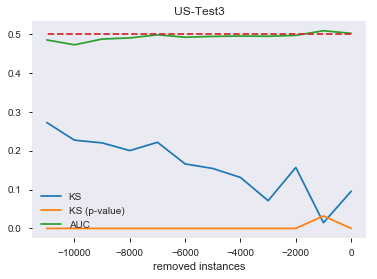

In [154]:
plot_results(score, [i*1000 for i in range(len(score))], 'US-Test3')

In [ ]:
y_pos = np.arange(len(us_columns))

plt.bar(y_pos, imp, align='center', alpha=0.5)
plt.xticks(y_pos, us_columns, rotation=90)
plt.ylabel('Importance')
plt.title('US REP REP - Feature Importance')
plt.show()

### US National Census (Income) <a name="us"></a>

*About this Dataset*

**US Adult Census** (1994) relates income to social factors: 

- *age*: continuous.
- *workclass*: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
- *fnlwgt*: continuous.
- *education*: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
- *education-num*: continuous.
- *marital-status*: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
- *occupation*: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
- *relationship*: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
- *race*: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
- *sex*: Female, Male.
- *capital-gain*: continuous.
- *capital-loss*: continuous.
- *hours-per-week*: continuous.
- *native-country*: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

Each row is labelled as either having a salary greater than ">50K" or "<=50K".

Note: This Dataset was obtained from the UCI repository, it can be found on

https://archive.ics.uci.edu/ml/datasets/census+income, http://mlr.cs.umass.edu/ml/machine-learning-databases/adult/

In [151]:
columns = ['Age','Workclass','fnlgwt','Education','Education Num','Marital Status',
           'Occupation','Relationship','Race','Sex','Capital Gain','Capital Loss',
           'Hours/Week','Country','Above/Below 50K']

train = pd.read_csv(os.path.join(path, 'data/census_income/adult.data'), names=columns)
test = pd.read_csv(os.path.join(path, 'data/census_income/adult.test'), names=columns)
test = test.iloc[1:]

df = pd.concat([train, test]).copy(deep=True)

del train, test

df.replace(' >50K.', ' >50K', inplace=True)
df.replace(' <=50K.', ' <=50K', inplace=True)

df.dropna(inplace=True)
df.reset_index(inplace=True, drop=True)

ctg = ['Workclass', 'Sex', 'Education', 'Marital Status', 
       'Occupation', 'Relationship', 'Race', 'Country']
for c in ctg:
    df = pd.concat([df, pd.get_dummies(df[c], 
                                       prefix=c,
                                       dummy_na=False)], axis=1).drop([c],axis=1)

'''Rep: <=50K    37155 ;; >50K     11687'''

df_high = df[df['Above/Below 50K'] == " >50K"].copy(deep=True)
df_low = df[df['Above/Below 50K'] == " <=50K"].copy(deep=True)

df_low = df_low.reindex(np.random.permutation(df_low.index))
df_high = df_high.reindex(np.random.permutation(df_high.index))

rep = pd.concat([df_low.head(5000).copy(deep=True),
                 df_high.head(5000).copy(deep=True)], sort=True)

nonrep = pd.concat([df_low.tail(5000).copy(deep=True),
                    df_high.tail(5000).copy(deep=True)], sort=True)

print('Rep: \n', rep['Above/Below 50K'].value_counts(), '\n')
print('Nonrep: \n', nonrep['Above/Below 50K'].value_counts())

nonrep['label'] = 1
rep['label'] = 0

del df, df_low, df_high

us = pd.concat([nonrep, rep], sort=True)

us_columns = list(us.columns)
meta = ['label', 'Above/Below 50K', 'index', 'bootstrap']
for m in meta:
    if m in us_columns:
        us_columns.remove(m)

us.reset_index(drop=True, inplace=True)
us.head()

Rep: 
  <=50K    5000
 >50K     5000
Name: Above/Below 50K, dtype: int64 

Nonrep: 
  <=50K    5000
 >50K     5000
Name: Above/Below 50K, dtype: int64


,Above/Below 50K,Age,Capital Gain,Capital Loss,Country_ ?,Country_ Cambodia,Country_ Canada,Country_ China,Country_ Columbia,Country_ Cuba,...,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,Workclass_ Private,Workclass_ Self-emp-inc,Workclass_ Self-emp-not-inc,Workclass_ State-gov,Workclass_ Without-pay,fnlgwt,label
0,<=50K,40,0.0,0.0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,434081.0,1
1,<=50K,59,0.0,0.0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,143372.0,1
2,<=50K,39,0.0,0.0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,279272.0,1
3,<=50K,42,0.0,0.0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,269028.0,1
4,<=50K,27,0.0,0.0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,104457.0,1


In [ ]:
allensbach = pd.read_csv(os.path.join(path, 'data/allensbach_mrs.csv'))

allensbach.drop(['Unnamed: 0'], axis=1, inplace=True)

allensbach_columns = ['BRS1', 'BRS2', 'BRS3', 'BRS4', 'BRS5', 'BRS6', 
                      'Berufsgruppe', 'Erwerbstätigkeit', 'Geschlecht',
                      'Optimismus', 'Pessimismus', 'Schulabschluss', 'woechentlicheArbeitszeit']
allensbach.head()

In [ ]:
gbs_p = pd.read_csv(os.path.join(path, 'data/gbs_processed.csv'), engine='python')
gesis_p = pd.read_csv(os.path.join(path, 'data/gesis_processed.csv'), engine='python')

gesis_p['label'] = 0
gbs_p['label'] = 1

gesis_columns = ['Geschlecht', 'Aktiv', 'Berufsgruppe', 'Schlechter Schlaf', 'Leben genießen',
       'Zu Nichts aufraffen', 'Alles anstrengend', 'Wahlteilnahme',
       'Wach', 'Zurueckhaltend', 'Resilienz', 'Zufriedenheit Wahlergebnis',
       'leicht Vertrauen', 'Faulheit', 'Entspannt',
       'wenig kuenstlerisches Interesse', 'Gesellig',
       'Andere kritisieren', 'Geburtsland', 'Geburtsjahr',
       'Personen im Haushalt', 'Nettoeinkommen Selbst',
       'Nettoeinkommen Haushalt', 'Schlechter Schlaf', 'Leben genießen',
       'Zu Nichts aufraffen', 'Alles anstrengend', 'Wahlteilnahme',
       'Wahlabsicht', 'Desinteresse Politiker',
       'Nationalitaet', 'Familienstand', 'Hoechster Bildungsabschluss',
       'Berufliche Ausbildung', 'Erwerbstaetigkeit', 
       'Gruendlich', 'Nervoes', 'Phantasievoll', 'Optimismus Zukunft']

gesis = pd.concat([gesis_p.copy(deep=True), gbs_p.copy(deep=True)], sort=True)
gesis.reset_index(drop=True, inplace=True)
gesis.fillna(gesis.median(), inplace=True)
gesis.head()

In [ ]:
score = []
n = []
imp = [0 for _ in range(len(gesis_columns))]

MRS(data=gesis, columns=gesis_columns, temperature=0.6, n_drop=20, limit=50)

In [ ]:
plot_results(score, n, 'GESIS-GBS')

In [ ]:
y_pos = np.arange(len(gesis_columns))

plt.bar(y_pos, imp, align='center', alpha=0.5)
plt.xticks(y_pos, gesis_columns, rotation=90)
plt.ylabel('Importance')
plt.title('GESIS - Feature Importance')
plt.show()

5th september 11h.